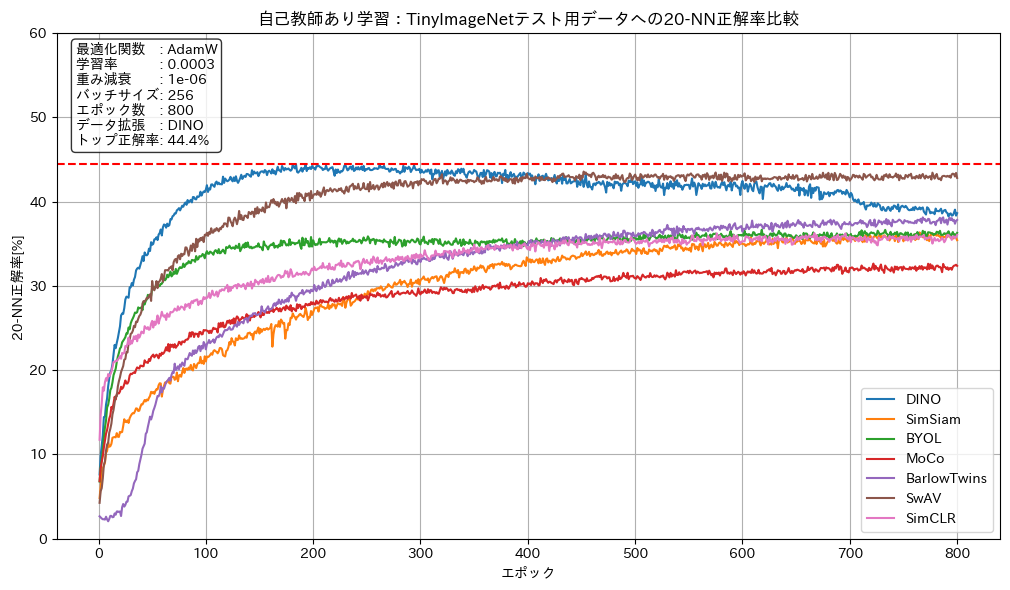

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob

def extract_scalar_arrays(scalar_events):
    wall_times, steps, values = [], [], []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)

def plot_scalar_values(paths_pattern, scalar_tag, title, xlabel, ylabel, ylim, hyperparameters):
    fig, ax = plt.subplots(figsize=(12, 6))
    best_accuracy = 0  # 最高の k-NN 精度を保持する変数

    for path in glob(paths_pattern):
        ssl = path.split('/')[-1]
        accumulator = EventAccumulator(f"{path}/DINO/{ssl}")
        accumulator.Reload()
        wall_times, steps, values = extract_scalar_arrays(accumulator.Scalars(scalar_tag))

        # 最高の k-NN 精度を探す
        max_accuracy = np.max(values)
        if max_accuracy > best_accuracy:
            best_accuracy = max_accuracy

        ax.plot(steps, values, label=ssl)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(*ylim)
    ax.grid(True)

    # ハイパーパラメータ情報を左上に表示
    hyperparam_text = (
        f"最適化関数　: {hyperparameters['name']}\n"
        f"学習率　　　: {hyperparameters['args']['lr']}\n"
        f"重み減衰　　: {hyperparameters['args']['weight_decay']}\n"
        f"バッチサイズ: {hyperparameters['batch_size']}\n"
        f"エポック数　: {hyperparameters['max_epoch']}\n"
        f"データ拡張　: {hyperparameters['transforms']}\n"
        f"トップ正解率: {best_accuracy:.1f}%"
    )
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.02, 0.98, hyperparam_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left', bbox=props)

    # レイアウト調整
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # 凡例を右下に配置
    ax.legend(loc='lower right')

    # 最高の k-NN 精度を横棒グラフで示す
    ax.axhline(y=best_accuracy, color='red', linestyle='--')

    plt.show()

if __name__ == "__main__":
    batch_size = 256
    optim_setting = {
        "name": "AdamW",
        "args": {
            "lr": 3e-4 * (batch_size / 256),
            "weight_decay": 1e-6,
        },
    }
    max_epoch = 800
    transforms = "DINO"

    hyperparameters = {
        "name": optim_setting["name"],
        "args": optim_setting["args"],
        "batch_size": batch_size,
        "max_epoch": max_epoch,
        "transforms": transforms,
    }

    plot_scalar_values(
        "runs/pre-train/resnet18/*",
        scalar_tag="test_top1",
        title="自己教師あり学習：TinyImageNetテスト用データへの20-NN正解率比較",
        xlabel="エポック",
        ylabel="20-NN正解率[%]",
        ylim=(0, 60),
        hyperparameters=hyperparameters
    )
